# Beachwatch Logistic Regressions

This analysis merges the Beachwatch and Environmental data packages, then does logistic regressions on bacteria counts versus  rainfal and riverflow. 


In [1]:
import matplotlib.pyplot as plt 
import metapack as mp
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

The beachwatch datasets we will be  using is derived from the original data, and includes an extra set of feature columns for measurement groups and the quantile of each measurement relative to its group. Refer to the [package README file for details about these aditional columns.](https://data.sandiegodata.org/dataset/sandiegodata-org-beachwatch)

In the schema below, note the columns that have '_group_' in the name, which are the group means and quantiles, and the  columsn that have comparison names, such as '_gt_' ( greater than )  '_gte_' ( greater than or equal ) or '_lte_' ( less than or equal. 

In [2]:
import metapack as mp
pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-beachwatch-4.zip')
pkg.resource('beachwatch')

Header,Type,Description
stationcode,string,Short name for the station
stationgroup,string,First two characters of station code
sampledate,datetime,Date sample was taken
collectiontime,time,Time sample was taken
measure_code,integer,"Reference to the measure codes, the unique groups of analyte, mehodname and unit."
analyte,string,"The type of bacterial being measured, for coliform, total coliform, Enterococcus or E. coli."
methodname,string,"Method used to count bacteria, such as “MTF”, “SM 9222 B” or “Enterolert”"
unit,string,"Measurement units, type of count per 100 ml."
result,integer,Measured value
result_group_count,integer,Number of records in this measurement group


In [3]:
beachwatch =    pkg.resource('beachwatch').read_csv(parse_dates=True)
measure_codes = pkg.resource('measure_codes').read_csv(parse_dates=True)
stations =      pkg.resource('stations').read_csv(parse_dates=True)

In [4]:
beachwatch.head()

,stationcode,stationgroup,sampledate,collectiontime,measure_code,analyte,methodname,unit,result,result_group_count,...,lresult_gt_lmedian,lresult_gt_lmean,lresult_lte_25pctl,lresult_gte_75pctl,labbatch,resultqualcode,qacode,sampleagency,labagency,submittingagency
0,EH-010,EH,1999-05-26,2018-11-15,0,"Coliform, Fecal",MTF,MPN/100 mL,20.0,213,...,0.0,0.0,0.0,1.0,SH-5/26/1999,<,NR,SDCDEH,SDCDEH,SDCDEH
1,EH-010,EH,1999-10-13,2018-11-15,0,"Coliform, Fecal",MTF,MPN/100 mL,0.0,213,...,0.0,0.0,0.0,0.0,SH-10/13/1999,=,NR,SDCDEH,SDCDEH,SDCDEH
2,EH-010,EH,1999-10-26,2018-11-15,0,"Coliform, Fecal",MTF,MPN/100 mL,20.0,213,...,0.0,0.0,0.0,1.0,SH-10/26/1999,<,NR,SDCDEH,SDCDEH,SDCDEH
3,EH-010,EH,2000-03-21,2018-11-15,0,"Coliform, Fecal",MTF,MPN/100 mL,20.0,213,...,0.0,0.0,0.0,1.0,SH-3/21/2000,<,NR,SDCDEH,SDCDEH,SDCDEH
4,EH-010,EH,2000-05-24,2018-11-15,0,"Coliform, Fecal",MTF,MPN/100 mL,230.0,213,...,1.0,1.0,0.0,1.0,SH-5/24/2000,=,NR,SDCDEH,SDCDEH,SDCDEH


In [5]:
beachwatch.lresult_gt_lmedian.value_counts(dropna=False)

0.0    136183
1.0     66074
Name: lresult_gt_lmedian, dtype: int64

Most of the time, when a result is creater than the mean, it is also greater than the median, and when it is less than the mean, it is also less than the median. 

In [6]:
# Proportion of gt_mean and gt_median that are different. 
_1 = beachwatch[['lresult_gt_lmedian','lresult_gt_lmedian']].dropna()

len(_1[beachwatch.lresult_gt_lmedian != beachwatch.lresult_gt_lmean])/len(_1)


0.043489224105964196

# Merge in environmental data

Now we can merge in the rain, river and tides dataset. 


In [7]:
env_pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-tides_rain_river-6.zip')

In [8]:
env_pkg.resource('tides_river_rain')

Header,Type,Description
date,date,date
discharge_rate,number,"Discharge rate, in cubic feet per second, for the San Diego River at Fashion Valley"
recent_total_discharge,number,Rolling three day sum of discharge_rate
recent_max_discharge,number,Rolling three day max of discharge_rate
dailyprecip,string,"Daily precipitation, in inches, at Lindberg Field"
recent_precip,number,Rolling three day sum of dailyprecip
wl_max,string,"Max ocean water level, in feet, at La Jolla"
wl_min,string,"Min water level, in feet, at La Jolla"


In [9]:
trr = env_pkg.resource('tides_river_rain').read_csv(parse_dates=True).set_index('date')
trr.head()

,discharge_rate,recent_total_discharge,recent_max_discharge,dailyprecip,recent_precip,wl_max,wl_min
date,,,,,,,
1988-01-01,22.0,22.0,22.0,NaN,NaN,NaN,NaN
1988-01-02,20.0,42.0,42.0,NaN,NaN,NaN,NaN
1988-01-03,18.0,60.0,60.0,NaN,NaN,NaN,NaN
1988-01-04,18.0,56.0,60.0,NaN,NaN,NaN,NaN
1988-01-05,21.0,57.0,60.0,NaN,NaN,NaN,NaN


We're going to use ``recent_precipt``, a three day rolling average, rather than ``dailyprecip`` because the bacteria samples are sporadic, and we don't want to use only measurements that were taken on the same day as rainfall, especially if a recent rainfall will increase the bacteria counts. 

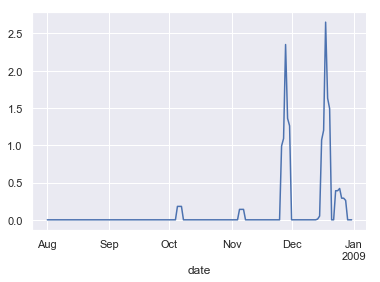

In [10]:
trr.loc['2007':'2008'].recent_precip.plot()

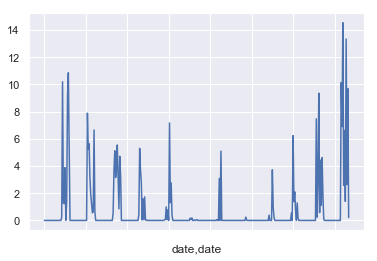

In [11]:
trr.groupby(by=[trr.index.month, trr.index.year]).sum().recent_precip.plot()

In [12]:
bw_env = beachwatch.set_index('sampledate').join(trr)
bw_env['high_flow'] =  (bw_env.recent_total_discharge > bw_env.recent_total_discharge.median()).astype(int)
bw_env['ldischarge_rate'] = np.log(bw_env.discharge_rate)


In [13]:
bw_env.head()

,stationcode,stationgroup,collectiontime,measure_code,analyte,methodname,unit,result,result_group_count,result_group_std,...,submittingagency,discharge_rate,recent_total_discharge,recent_max_discharge,dailyprecip,recent_precip,wl_max,wl_min,high_flow,ldischarge_rate
1998-07-21,SE-010,SE,2018-11-15,0,"Coliform, Fecal",MTF,MPN/100 mL,4.0,527,225.561709,...,SEJPA,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1,2.174752
1998-07-21,SE-010,SE,2018-11-15,9,"Coliform, Total",MTF,MPN/100 mL,4.0,530,309.086717,...,SEJPA,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1,2.174752
1998-07-21,SE-010,SE,2018-11-15,26,Enterococcus,MTF,MPN/100 mL,2.0,488,148.631518,...,SEJPA,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1,2.174752
1998-07-21,SE-020,SE,2018-11-15,0,"Coliform, Fecal",MTF,MPN/100 mL,23.0,477,128.262880,...,SEJPA,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1,2.174752
1998-07-21,SE-020,SE,2018-11-15,9,"Coliform, Total",MTF,MPN/100 mL,23.0,477,263.711243,...,SEJPA,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1,2.174752


## Sanity Checking and Exploration

Let's look at a few of the variables to see if they are sensible. 

In [14]:
# The values are 1 or 0, so a sum is equivalent to a count. 
sum(bw_env.recent_precip > 0.0), sum(bw_env.recent_precip > 0.0)/len(bw_env)

(8440, 0.041729087250379465)

The mean discharge rate is a lot larger for the above mean results compared to the below mean results. 

In [15]:
bw_env.groupby('lresult_gt_lmean').mean().discharge_rate.reset_index()

,lresult_gt_lmean,discharge_rate
0,0.0,10.482232
1,1.0,47.200024


However, it looks like all of that difference is due to a small number of high-flow events. Both plots have very long tails. 

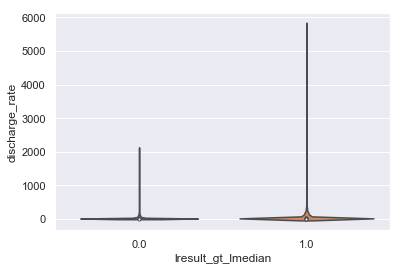

In [16]:
ax = sns.violinplot(x=bw_env.lresult_gt_lmedian, y=bw_env.discharge_rate)

Looking at the plot of the log discharge reveals the patterns better.

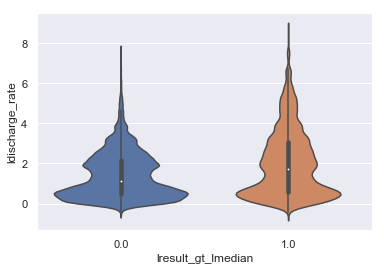

In [17]:
ax = sns.violinplot(x=bw_env.lresult_gt_lmedian, y=bw_env.ldischarge_rate)

In [18]:
bw_env.groupby('lresult_gt_lmean').discharge_rate.agg(['mean','std','median'])

,mean,std,median
lresult_gt_lmean,,,
0.0,10.482232,36.187658,3.15
1.0,47.200024,195.216645,5.70


In [19]:
bw_env.groupby('lresult_gt_lmean').mean().recent_precip

lresult_gt_lmean
0.0    0.024758
1.0    0.129421
Name: recent_precip, dtype: float64

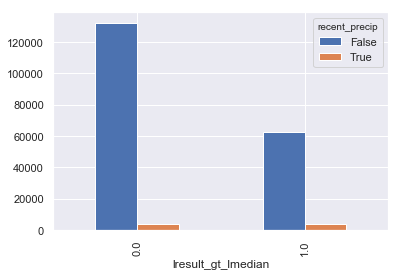

In [20]:
pd.crosstab(bw_env.lresult_gt_lmedian, bw_env.recent_precip > 0.01 ).plot(kind='bar')

# Logistic Regressions

Logistic regression produces a model for estimating the probablity of a binary dependent varaible. We will use this to determine the probability that the bacteria count result is above the group median given the recent ( 3 day rolling average) precipitation. 

We'll focus on measure code 24, which is the largest group of Enterroccous measurements using Enterlert. However, before running the regression, we'll set up a linear regression as an example to explain how the logistic regression works. 

The goal of the logistic regression is to create a curve of probabilities that the bacteria measurement will be greater than the median given the precipitation. So, if we know the preciptation, we can estimate the probability that the bacteria measurement will be high. First we'll motivate the process using the simipler method of linear regression. 

First, prepare a simple dataframe for the regression. Note that the y variable is binary, either 0, for not above the median, and 1 if the measurement is above the median. The X value, precipitation, is continuous. 


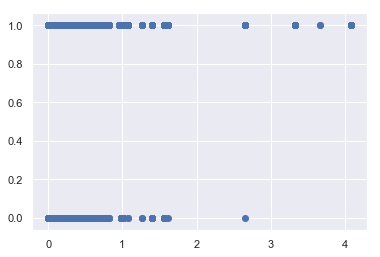

In [21]:
_1 = bw_env[(bw_env.measure_code==24)]

_2 = pd.DataFrame()

_2['y'] = _1.lresult_gt_lmedian 
_2['X'] = _1.recent_precip.fillna(0)

_2.sort_values('X', inplace=True)

lr = _2

plt.scatter(lr['X'],lr['y'])

## Using Linear Regression

To better explain how logistic regression works, we'll start by trying to solve the problem with linear regression. 

Scikit learn is just one of the many packages that provides linear regression. Here we will extract the regression coefficients ( they are stored in ``linreg`` ), and then, using ``linreg`` create a new prediction of the ``y`` variable from the ``X`` variable. 

Note that the ``X`` variable is referenced with an array; the fit and predict functions expect dataframes of 1 or more columns, not Series. 


In [22]:
# fit a linear regression model
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

linreg.fit(lr[['X']], lr['y'])

lr['predict_lin'] = linreg.predict(lr[['X']])

/Users/eric/proj/virt/water/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Now that we have a prediction, we can plot the line and the points. The blue points are the values for precipitation,  divided into those with  rows for measurements above the median, and those with measurements below. The red line is the regression through those points, and the green is a decision curve that transitions from 0 to 1 at the point that the regression line has a y value of 0.5, the point where the expected probability of the measurement being above the median is more likely than not. 

Note that the red regression line extends above y=1. Since our prediction is supposed to be either 0 or 1, this is nonsense. Logistic regression instead tries to fit a logictic curve, which is 0 at x=0 and 1 when x is large, which is much more sensible. 

Also note that there are a lot of points for y=0 to the right of the decision line. These are points are errors,  for which the regression would predict that the result would be above the median, when in fact it was below.


[0.33075766] 0.24598895530104442


Text(0,0.5,'> median')

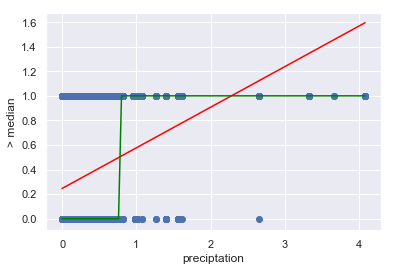

In [23]:
plt.scatter(lr['X'],lr['y'])
plt.plot(lr['X'],lr['predict_lin'], color='red')  

# Here is the decision line -- where the prediction linear line
# crosses .5
plt.plot(lr['X'], np.where(_2['predict_lin'] >= 0.5, 1, 0), color='green')
print(linreg.coef_, linreg.intercept_)
plt.xlabel('preciptation')
plt.ylabel('> median')

## Logistic Regression using Sklearn

Much of the sklearn examples come from:

http://nbviewer.jupyter.org/github/justmarkham/DAT8/blob/master/notebooks/12_logistic_regression.ipynb

Here we tackle a similar problem to the linear regression process, but instead use logistic regression. First we will use scikit's LogisticRegression to plot the class predictions curve, then the predictied prbabilities curve.


In [24]:

# fit a logistic regression model and store the class predictions
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)

logreg.fit(lr[['X']], lr['y'])
lr['predict_log'] = logreg.predict(lr[['X']])

Here are the class predictions, which transitions from 0 to 1, as in the linear regression example.


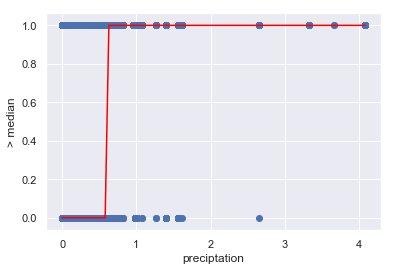

In [25]:
# plot the class predictions

plt.scatter(lr['X'],lr['y']) # The blue dots

plt.plot(lr['X'],lr['predict_log'], color='red') # The red line1
plt.xlabel('preciptation')
plt.ylabel('> median');

While analysis can use the 0 or 1 class prediction curve, which always predicts either 0 or 1, it may be more realistic to generate probabilities that the value is greater than the median.  The predicted probabilities are usually an "S curve" -- also known as the logistic curve, from which the regression gets its name --  with a left tail that asymptotically approches 0, and 1 on the right. 

The curve for this dataset is a bit wacked, since it never predicts 0, regardless of how low the precipitation is. This suggests that there is some other factor that we should include in the model. However, the curve is 1 at higher precipitation values, suggesting that for higher precipitation, the other unknown factor is not so important. 

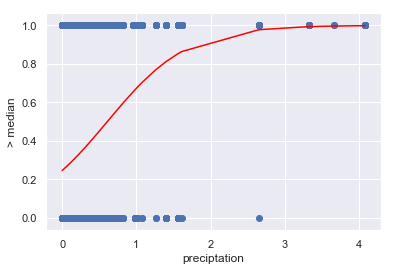

In [26]:

# store the predicted probabilites of class 1
lr['predict_prob'] = logreg.predict_proba(lr[['X']])[:, 1]

# plot the predicted probabilities
plt.scatter(lr['X'],lr['y'])

plt.plot(lr['X'],lr['predict_prob'], color='red')
plt.xlabel('preciptation')
plt.ylabel('> median');

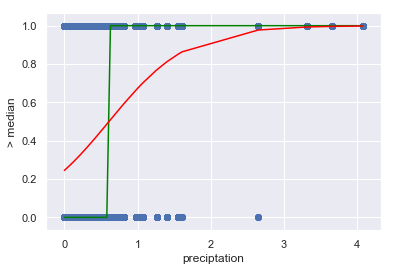

In [27]:
def sklearn_lr(y,X):
    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression(C=1e9)

    lr = pd.DataFrame()
   
    lr['X'] = X
    lr['y'] = y
    
    lr.sort_values('X', inplace=True)
    
    logreg.fit(lr[['X']], lr['y'])
    lr['predict_log'] = logreg.predict(lr[['X']])
    
    plt.scatter(lr['X'],lr['y'], color='blue') # The blue dots

    plt.plot(lr['X'],lr['predict_log'], color='green') # The red line1
    plt.xlabel('preciptation')
    plt.ylabel('> median');
    
    # store the predicted probabilites of class 1
    lr['predict_prob'] = logreg.predict_proba(lr[['X']])[:, 1]

    # plot the predicted probabilities
    plt.scatter(lr['X'],lr['y'])

    plt.plot(lr['X'],lr['predict_prob'], color='red')
    plt.xlabel('preciptation')
    plt.ylabel('> median');
    

sklearn_lr(lr.y,lr.X)    



Here are the coefficients, which we can compare to those of the statsmodel code in the next section.


In [28]:
"X coef={}, intercept={}".format(logreg.coef_[0], logreg.intercept_)


'X coef=[1.84627449], intercept=[-1.12573655]'

# Logistic Regression Using Statsmodel

Here is a function to do the same sort of logistic regression using statsmodel. 


In [29]:
def logit(y,X):
    import statsmodels.api as sm

    X_ = pd.DataFrame()
   
    X_['X'] = X
    X_['const'] = 1

    logit_model=sm.Logit(y,X_)
    result=logit_model.fit()
    print(result.summary())

    # Odds ratio and conf interval
    params = result.params
    conf = result.conf_int()
    conf['OR'] = params
    conf.columns = ['2.5%', '97.5%', 'OR']
    print(np.exp(conf))
  

Let's do the same regresion as we did in the previous section with sklear and compare the coefficients. They are the same. 

In [30]:
logit(lr['y'],lr['X'])

Optimization terminated successfully.
         Current function value: 0.558891
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40349
Model:                          Logit   Df Residuals:                    40347
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Nov 2018   Pseudo R-squ.:                 0.01177
Time:                        20:13:59   Log-Likelihood:                -22551.
converged:                       True   LL-Null:                       -22819.
                                        LLR p-value:                8.516e-119
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.8463      0.093     19.876      0.000       1.664       2.028
const         -1.1257      0.

# Logistic Regression Exploration

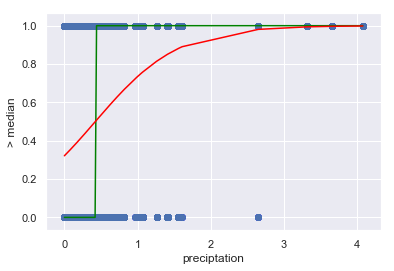

In [31]:
sklearn_lr(
    y = bw_env.lresult_gt_lmedian.astype(int), 
    X = bw_env.recent_precip.fillna(0)
)


# Rain Seasonality

Maybe there is a stonger correlation to precipitation in the first rains of the season? The guess is that late in the season, pollutants and nutrients have already been washed out by the early rains, so there should be more pollution earlier in the season. 


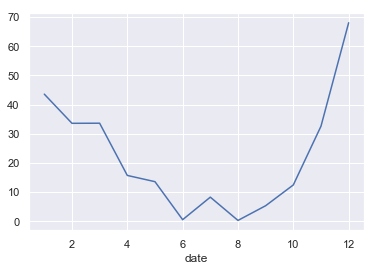

In [32]:
trr.groupby(trr.index.month).sum().recent_precip.plot()

Here we calculate rainfall quartiles. A value of 1, the first quartile, includes all of the months of the year that have total rainfall less than the 25% percentile ( actually 30th, see comment ) while a value of 4 is months with rainfall greater than the 75% percentile. 

In [33]:
# Compute the quartile of rainfall for each month

_1 = pd.qcut(trr.groupby(trr.index.month).sum().recent_precip, 
             q=[0, .3, .5, .75, 1.], # .3 not .25 to smooth out summer
            labels=[1,2,3,4])

dmap = {e['date']:e['recent_precip'] for _,e in _1.to_frame().reset_index().iterrows()}

#trr.apply( lambda row: dmap[row.index.month])
bw_env['month'] = bw_env.index.month
bw_env['precip_month_q'] = bw_env.month.apply(lambda v: dmap[v])


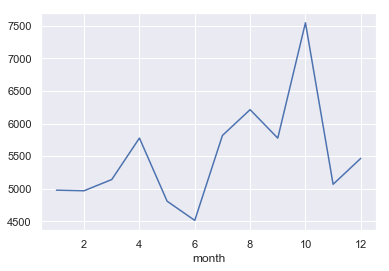

In [34]:
bw_env.groupby(bw_env.month).lresult_gt_lmedian.sum().plot()

By grouping by the month quartile, we can see that days in the 75% percentile months get about 50x the rain of the 25% percentile months. 

In [35]:
bw_env.groupby(bw_env['precip_month_q']).recent_precip.mean()

precip_month_q
1    0.002756
2    0.027152
3    0.108754
4    0.153864
Name: recent_precip, dtype: float64

However, there are more days of above median results in the 1st quartile months than in any of the others. 

In [36]:
bw_env.groupby(bw_env['precip_month_q']).lresult_gt_lmedian.sum()

precip_month_q
1    22320.0
2    12355.0
3    15814.0
4    15585.0
Name: lresult_gt_lmedian, dtype: float64

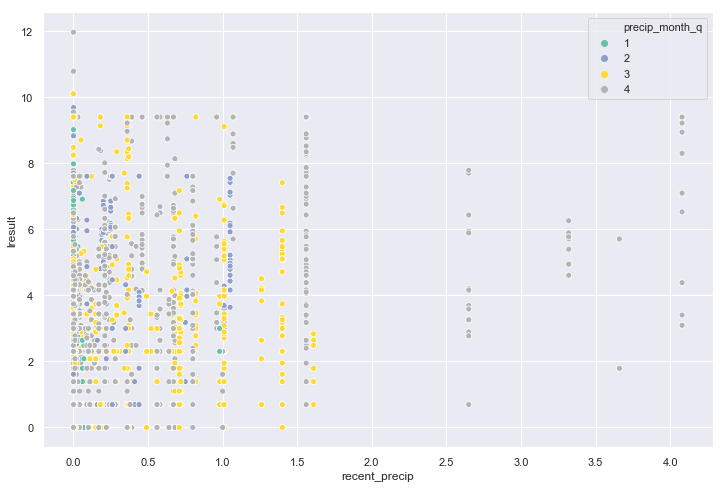

In [37]:
_1 = bw_env[(bw_env.measure_code==24)]

fig, ax = plt.subplots(figsize=(12,8))

ax = sns.scatterplot(ax=ax, x="recent_precip", y="lresult", hue="precip_month_q", palette="Set2", data=_1)


The quantization in the chart above -- the vertical strips of points -- is very suspicious. Lets look at the records for the largest value.  It appears that there were many measreuemnts taken at many different stations, so they all share the same value for ``recent_precip``

In [38]:
bw_env[bw_env.recent_precip == bw_env.recent_precip.max()][['stationcode', 'measure_code','collectiontime']].head()

,stationcode,measure_code,collectiontime
2010-12-23,IB-030,2,2018-11-15 11:00:00
2010-12-23,IB-030,11,2018-11-15 11:00:00
2010-12-23,IB-030,24,2018-11-15 11:00:00
2010-12-23,IB-040,2,2018-11-15 11:11:00
2010-12-23,IB-040,11,2018-11-15 11:11:00
